In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import scanpy as sc
import copy
import matplotlib.pyplot as plt
import anndata as ad
import scipy.stats
from PlotConfusion import plot_confusion
from PlotConfusion import plot_batchbar
from numpy.random import default_rng
from harmony import harmonize
from sklearn.utils import shuffle
from scipy.stats import ttest_ind
from scipy.stats import entropy

rng = default_rng()

In [2]:
ref_adata = sc.read_h5ad('path/to/adatas/P56_adata.h5ad')

In [3]:
test_adata = sc.read_h5ad('path/to/adatas/P7b2_adata_filtered.h5ad')

In [4]:
test_adata.obs['Type_num'] = test_adata.obs['Cluster']

In [5]:
original_metadata = pd.read_csv('C:/Users/pomat/Documents/PhD/Research/RGC_P56_metadata.txt',sep='\t')
original_clusters = original_metadata['old_clusters']

In [7]:
ref_clusters = []
ref_batches = []
for i in range(len(original_clusters)):
    ref_cluster = "C" + str(original_clusters[i])
    ref_clusters.append(ref_cluster)
    ref_batches.append('Ref_'+ref_adata.obs['Batch'][i])
ref_adata.obs['Cluster'] = pd.Categorical(ref_clusters)
ref_adata.obs['Type_num'] = pd.Categorical(original_clusters)
ref_adata.obs['Atlas_batch'] = pd.Categorical(ref_batches)

In [8]:
test_type_nums = []
test_batches = []
for i in range(len(test_adata.obs['Type_num'])):
    test_type_num = test_adata.obs['Type_num'][i].strip('C')
    test_type_nums.append(int(test_type_num))
    test_batches.append('Ref_'+test_adata.obs['Batch'][i])
test_adata.obs['Cluster'] = test_adata.obs['Type_num'].copy()
test_adata.obs['Type_num'] = pd.Categorical(test_type_nums)
test_adata.obs['Atlas_batch'] = pd.Categorical(test_batches)

In [33]:
ref_highly_var = [ref_adata.var['highly_variable'].index[i] for i in range(len(ref_adata.var['highly_variable'])) if ref_adata.var['highly_variable'][i]] #_copy
test_highly_var = [test_adata.var['highly_variable'].index[i] for i in range(len(test_adata.var['highly_variable'])) if test_adata.var['highly_variable'][i]] #_copy
common_highly_var = [i for i in ref_highly_var if i in test_highly_var]

In [34]:
ref_adata = ref_adata[:, common_highly_var]
test_adata = test_adata[:, common_highly_var]

In [35]:
sc.pp.scale(ref_adata)
sc.pp.scale(test_adata)

C:\Users\pomat\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\preprocessing\_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [36]:
n_ref_clusters = len(ref_adata.obs['Type_num'].unique())
ref_data = ref_adata.X
ref_labels = [i-1 for i in ref_adata.obs['Type_num']]
ref_batches = [i for i in ref_adata.obs['Batch']]

In [37]:
clustered_ref_train_data = []
clustered_ref_validation_data = []
clustered_ref_train_batches = []
clustered_ref_validation_batches = []
for i in range(n_ref_clusters):
    n_cells = ref_labels.count(i)
    n_cells_60 = int(round(0.6*n_cells, 0))
    cluster_data = [ref_data[j] for j in range(ref_data.shape[0]) if ref_labels[j] == i]
    cluster_batches = [ref_batches[j] for j in range(len(ref_batches)) if ref_labels[j] == i]
    if 300 > n_cells_60:
        indices = rng.choice(n_cells, size=n_cells_60, replace=False)
        cluster_train = [cluster_data[j] for j in indices]
        cluster_train_batches = [cluster_batches[j] for j in indices]
        anti_indices = [j for j in np.arange(n_cells) if j not in indices]
        cluster_validation = [cluster_data[j] for j in anti_indices]
        cluster_validation_batches = [cluster_batches[j] for j in anti_indices]
    else:
        indices = rng.choice(n_cells, size=300, replace=False)
        cluster_train = [cluster_data[j] for j in indices]
        cluster_train_batches = [cluster_batches[j] for j in indices]
        anti_indices = [j for j in np.arange(n_cells) if j not in indices]
        cluster_validation = [cluster_data[j] for j in anti_indices]
        cluster_validation_batches = [cluster_batches[j] for j in anti_indices]
    clustered_ref_train_data.append(np.array(cluster_train))
    clustered_ref_validation_data.append(np.array(cluster_validation))
    clustered_ref_train_batches.append(np.array(cluster_train_batches))
    clustered_ref_validation_batches.append(np.array(cluster_validation_batches))

In [38]:
unclustered_ref_train_data = []
unclustered_ref_train_labels = []
unclustered_ref_train_batches = []
unclustered_ref_validation_data = []
unclustered_ref_validation_labels = []
unclustered_ref_validation_batches = []
for i in range(len(clustered_ref_train_data)):
    [unclustered_ref_train_data.append(j) for j in clustered_ref_train_data[i]]
    [unclustered_ref_train_labels.append(j) for j in len(clustered_ref_train_data[i])*[i]]
    [unclustered_ref_train_batches.append(j) for j in clustered_ref_train_batches[i]]
    [unclustered_ref_validation_data.append(j) for j in clustered_ref_validation_data[i]]
    [unclustered_ref_validation_labels.append(j) for j in len(clustered_ref_validation_data[i])*[i]]
    [unclustered_ref_validation_batches.append(j) for j in clustered_ref_validation_batches[i]]

In [39]:
xgb_ref_params = {'objective': 'multi:softprob', 'eval_metric': 'mlogloss', 'num_class': n_ref_clusters, 'eta': 0.2, 'max_depth': 6, 'subsample': 0.6}
ref_dtrain = xgb.DMatrix(unclustered_ref_train_data, label=unclustered_ref_train_labels, feature_names=list(ref_adata.var_names))
ref_model = xgb.train(xgb_ref_params, ref_dtrain)

In [40]:
def validate(validation_data, n_clusters, model, model_feature_names):
    validation_errors = []
    for i in range(n_clusters):
        dtest = xgb.DMatrix(validation_data[i], feature_names=model_feature_names)
        predict_softcluster = model.predict(dtest)
        predict_labels = [np.argmax(j) for j in predict_softcluster]
        misclass = 0
        for j in range(len(predict_labels)):
            if predict_labels[j] != i:
                misclass += 1
        validation_errors.append(misclass/len(predict_labels))

    return validation_errors

In [41]:
def validation_plot(validation_data, validation_labels, validation_batches, model, model_feature_names, cname, bname):
    dtest = xgb.DMatrix(validation_data, feature_names=model_feature_names)
    predict_softcluster = model.predict(dtest)
    predict_labels = [np.argmax(j)+1 for j in predict_softcluster]
    cplot = plot_confusion(predict_labels, validation_labels, cname, 'Cluster', 'Prediction')
    bplot = plot_batchbar(labels=predict_labels, batches=validation_batches, figname=bname)

In [42]:
ref_validation_errors = validate(clustered_ref_validation_data, n_ref_clusters, ref_model, list(ref_adata.var_names))

In [43]:
new_unclustered_ref_train_data = unclustered_ref_train_data.copy()
new_unclustered_ref_train_labels = unclustered_ref_train_labels.copy()
ref_train_sizes = [len(clustered_ref_train_data[i]) for i in range(len(clustered_ref_train_data))]
max_ref_train_size = max(ref_train_sizes)
for i in range(n_ref_clusters):
    if (ref_train_sizes[i] < max_ref_train_size) & (ref_validation_errors[i] > 0.1):
        upsample_size = max_ref_train_size-ref_train_sizes[i]
        upsampled_cells = rng.choice(clustered_ref_validation_data[i], size=upsample_size)
        new_unclustered_ref_train_data = np.concatenate((new_unclustered_ref_train_data, upsampled_cells), axis=0)
        new_unclustered_ref_train_labels = np.append(new_unclustered_ref_train_labels, upsample_size*[i])
ref_new_dtrain = xgb.DMatrix(new_unclustered_ref_train_data,label=new_unclustered_ref_train_labels)
ref_model = xgb.train(xgb_ref_params, ref_new_dtrain)
ref_validation_errors = validate(clustered_ref_validation_data, n_ref_clusters, ref_model, list(ref_adata.var_names))
print(pd.DataFrame(ref_validation_errors))

           0
0   0.029630
1   0.069949
2   0.040828
3   0.045918
4   0.102473
5   0.045736
6   0.056294
7   0.124217
8   0.058505
9   0.074713
10  0.066667
11  0.059724
12  0.057543
13  0.080000
14  0.054867
15  0.043478
16  0.047348
17  0.142586
18  0.077895
19  0.102190
20  0.064599
21  0.129032
22  0.086379
23  0.043478
24  0.103306
25  0.038462
26  0.078603
27  0.032258
28  0.075000
29  0.071429
30  0.140449
31  0.042945
32  0.186047
33  0.064000
34  0.048387
35  0.053191
36  0.070588
37  0.012048
38  0.024691
39  0.028571
40  0.020000
41  0.066667
42  0.000000
43  0.000000
44  0.000000


In [44]:
true_ref_labels = [i+1 for i in unclustered_ref_validation_labels]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]


C:\Users\pomat\Documents\PhD\Research\B2 Paper\PlotConfusion.py:103: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(['0%','20%','40%','60%','80%','100%'])


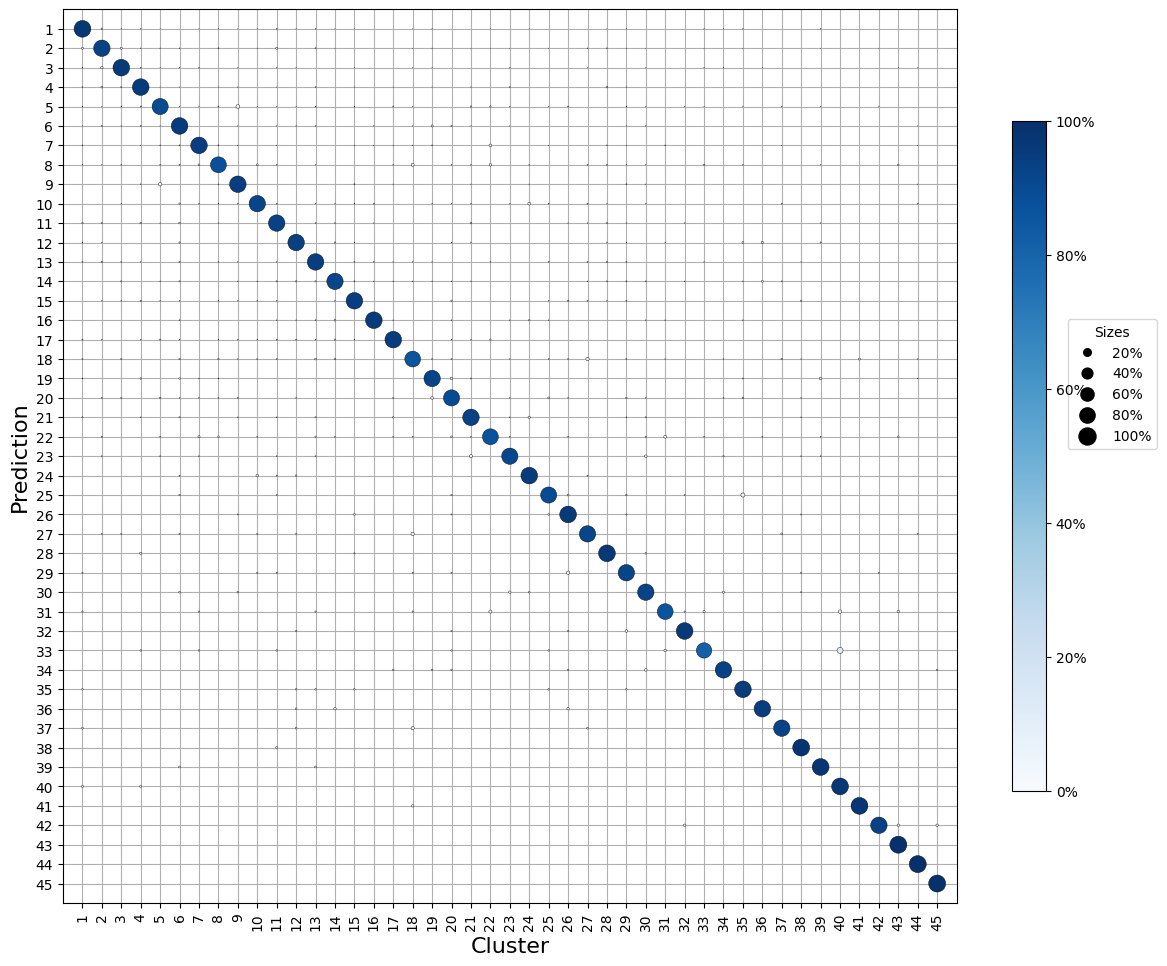

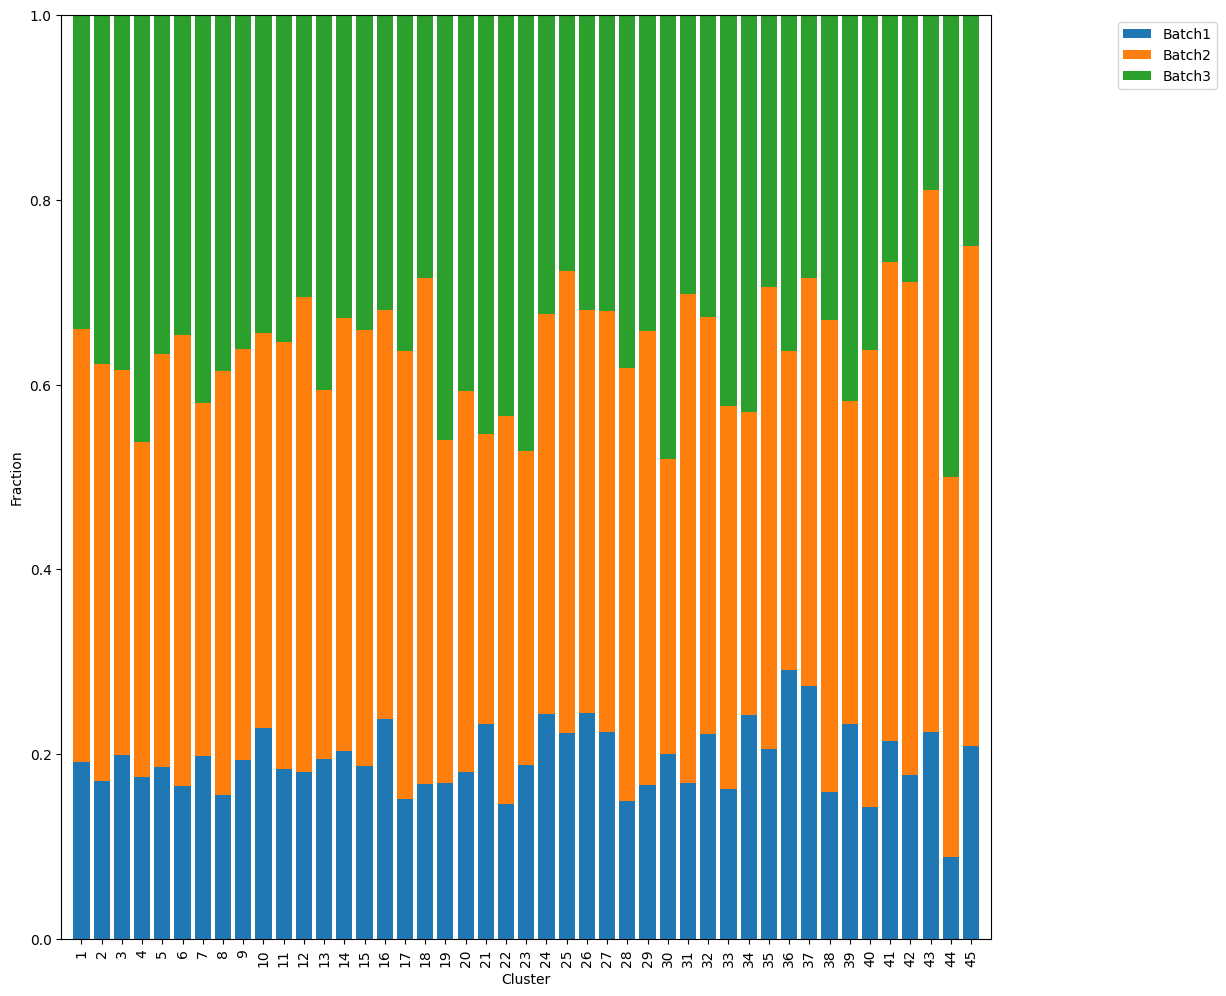

In [45]:
validation_plot(unclustered_ref_validation_data, true_ref_labels, unclustered_ref_validation_batches, ref_model, list(ref_adata.var_names), 'New_P56_Validation.pdf', 'New_P56_Barplot.pdf')

In [46]:
n_test_clusters = len(test_adata.obs['Type_num'].unique())
test_data = test_adata.X
test_labels = [i-1 for i in test_adata.obs['Type_num']]
test_batches = [i for i in test_adata.obs['Batch']]

In [47]:
clustered_test_train_data = []
clustered_test_validation_data = []
clustered_test_train_batches = []
clustered_test_validation_batches = []
for i in range(n_test_clusters):
    n_cells = test_labels.count(i)
    n_cells_60 = int(round(0.6*n_cells, 0))
    cluster_data = [test_data[j] for j in range(test_data.shape[0]) if test_labels[j] == i]
    cluster_batches = [test_batches[j] for j in range(len(test_batches)) if test_labels[j] == i]
    if 300 > n_cells_60:
        indices = rng.choice(n_cells, size=n_cells_60, replace=False)
        cluster_train = [cluster_data[j] for j in indices]
        cluster_train_batches = [cluster_batches[j] for j in indices]
        anti_indices = [j for j in np.arange(n_cells) if j not in indices]
        cluster_validation = [cluster_data[j] for j in anti_indices]
        cluster_validation_batches = [cluster_batches[j] for j in anti_indices]
    else:
        indices = rng.choice(n_cells, size=300, replace=False)
        cluster_train = [cluster_data[j] for j in indices]
        cluster_train_batches = [cluster_batches[j] for j in indices]
        anti_indices = [j for j in np.arange(n_cells) if j not in indices]
        cluster_validation = [cluster_data[j] for j in anti_indices]
        cluster_validation_batches = [cluster_batches[j] for j in anti_indices]
    clustered_test_train_data.append(np.array(cluster_train))
    clustered_test_validation_data.append(np.array(cluster_validation))
    clustered_test_train_batches.append(np.array(cluster_train_batches))
    clustered_test_validation_batches.append(np.array(cluster_validation_batches))

In [48]:
unclustered_test_train_data = []
unclustered_test_train_labels = []
unclustered_test_train_batches = []
unclustered_test_validation_data = []
unclustered_test_validation_labels = []
unclustered_test_validation_batches = []
for i in range(len(clustered_test_train_data)):
    [unclustered_test_train_data.append(j) for j in clustered_test_train_data[i]]
    [unclustered_test_train_labels.append(j) for j in len(clustered_test_train_data[i])*[i]]
    [unclustered_test_train_batches.append(j) for j in clustered_test_train_batches[i]]
    [unclustered_test_validation_data.append(j) for j in clustered_test_validation_data[i]]
    [unclustered_test_validation_labels.append(j) for j in len(clustered_test_validation_data[i])*[i]]
    [unclustered_test_validation_batches.append(j) for j in clustered_test_validation_batches[i]]

In [49]:
xgb_test_params = {'objective': 'multi:softprob', 'eval_metric': 'mlogloss', 'num_class': n_test_clusters, 'eta': 0.2, 'max_depth': 6, 'subsample': 0.6}
test_dtrain = xgb.DMatrix(unclustered_test_train_data,label=unclustered_test_train_labels, feature_names=list(test_adata.var_names))
test_model = xgb.train(xgb_test_params, test_dtrain)

In [50]:
test_validation_errors = validate(clustered_test_validation_data, n_test_clusters, test_model, list(test_adata.var_names))

In [51]:
new_unclustered_test_train_data = unclustered_test_train_data.copy()
new_unclustered_test_train_labels = unclustered_test_train_labels.copy()
test_train_sizes = [len(clustered_test_train_data[i]) for i in range(len(clustered_test_train_data))]
max_test_train_size = max(test_train_sizes)
for i in range(n_test_clusters):
    if (test_train_sizes[i] < max_test_train_size) & (test_validation_errors[i] > 0.1):
        upsample_size = max_test_train_size-test_train_sizes[i]
        upsampled_cells = rng.choice(clustered_test_validation_data[i], size=upsample_size)
        new_unclustered_test_train_data = np.concatenate((new_unclustered_test_train_data, upsampled_cells), axis=0)
        new_unclustered_test_train_labels = np.append(new_unclustered_test_train_labels, upsample_size*[i])
test_new_dtrain = xgb.DMatrix(new_unclustered_test_train_data,label=new_unclustered_test_train_labels)
test_model = xgb.train(xgb_test_params, test_new_dtrain)
test_validation_errors = validate(clustered_test_validation_data, n_test_clusters, test_model, list(test_adata.var_names))
print(pd.DataFrame(test_validation_errors))

           0
0   0.114659
1   0.122558
2   0.063768
3   0.067485
4   0.065147
5   0.030508
6   0.054983
7   0.047794
8   0.122530
9   0.048889
10  0.054348
11  0.076923
12  0.033333
13  0.067568
14  0.102041
15  0.068027
16  0.075342
17  0.068966
18  0.072464
19  0.046512
20  0.032520
21  0.114754
22  0.090909
23  0.050000
24  0.067227
25  0.077586
26  0.060870
27  0.061404
28  0.081818
29  0.125000
30  0.019608
31  0.020408
32  0.010638
33  0.086022
34  0.057471
35  0.000000
36  0.083333
37  0.000000
38  0.038961
39  0.000000
40  0.027778
41  0.161765
42  0.000000
43  0.019231
44  0.000000
45  0.020833
46  0.027778
47  0.088235
48  0.000000
49  0.000000
50  0.000000
51  0.000000


In [52]:
true_test_labels = [i+1 for i in unclustered_test_validation_labels]

In [53]:
len(unclustered_test_validation_data)

7613

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52]


C:\Users\pomat\Documents\PhD\Research\B2 Paper\PlotConfusion.py:103: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(['0%','20%','40%','60%','80%','100%'])


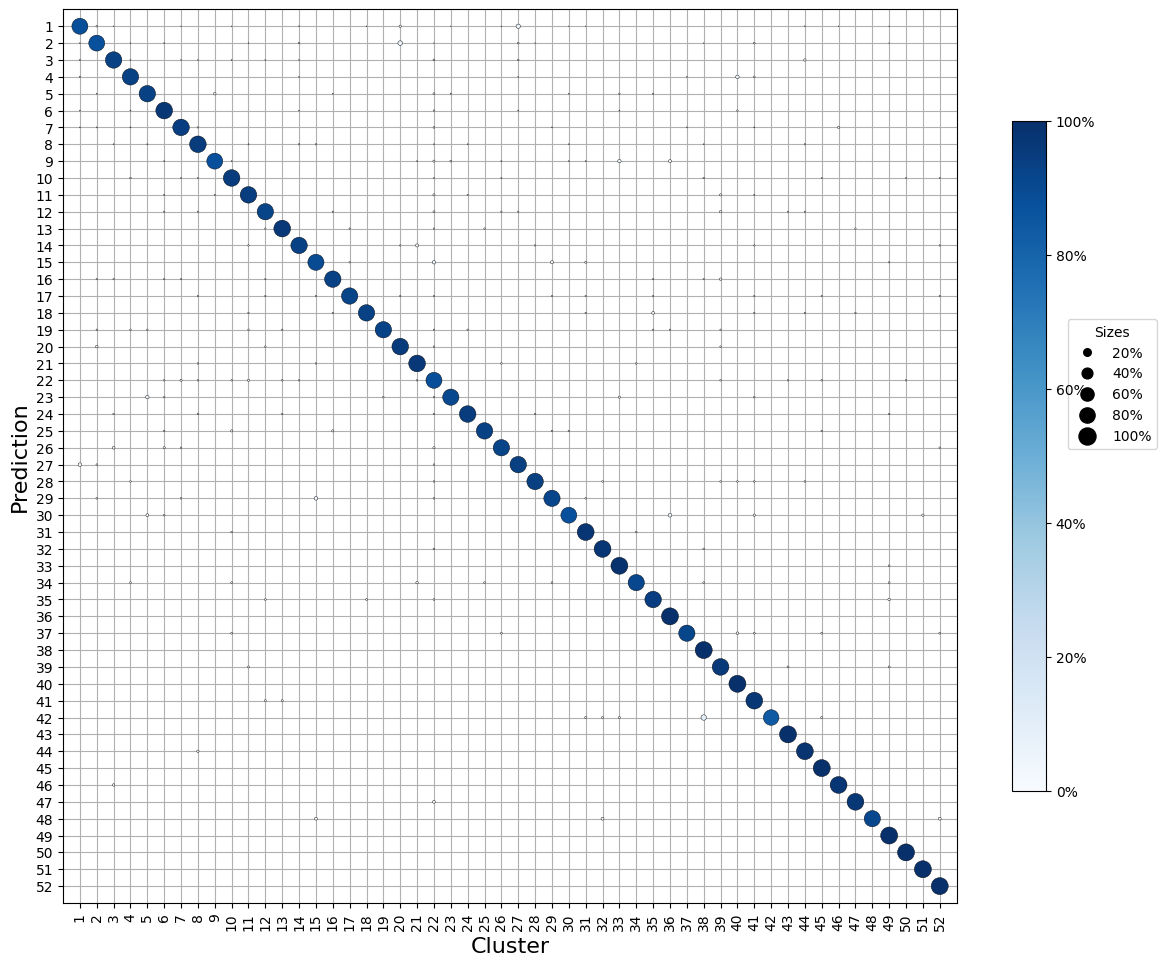

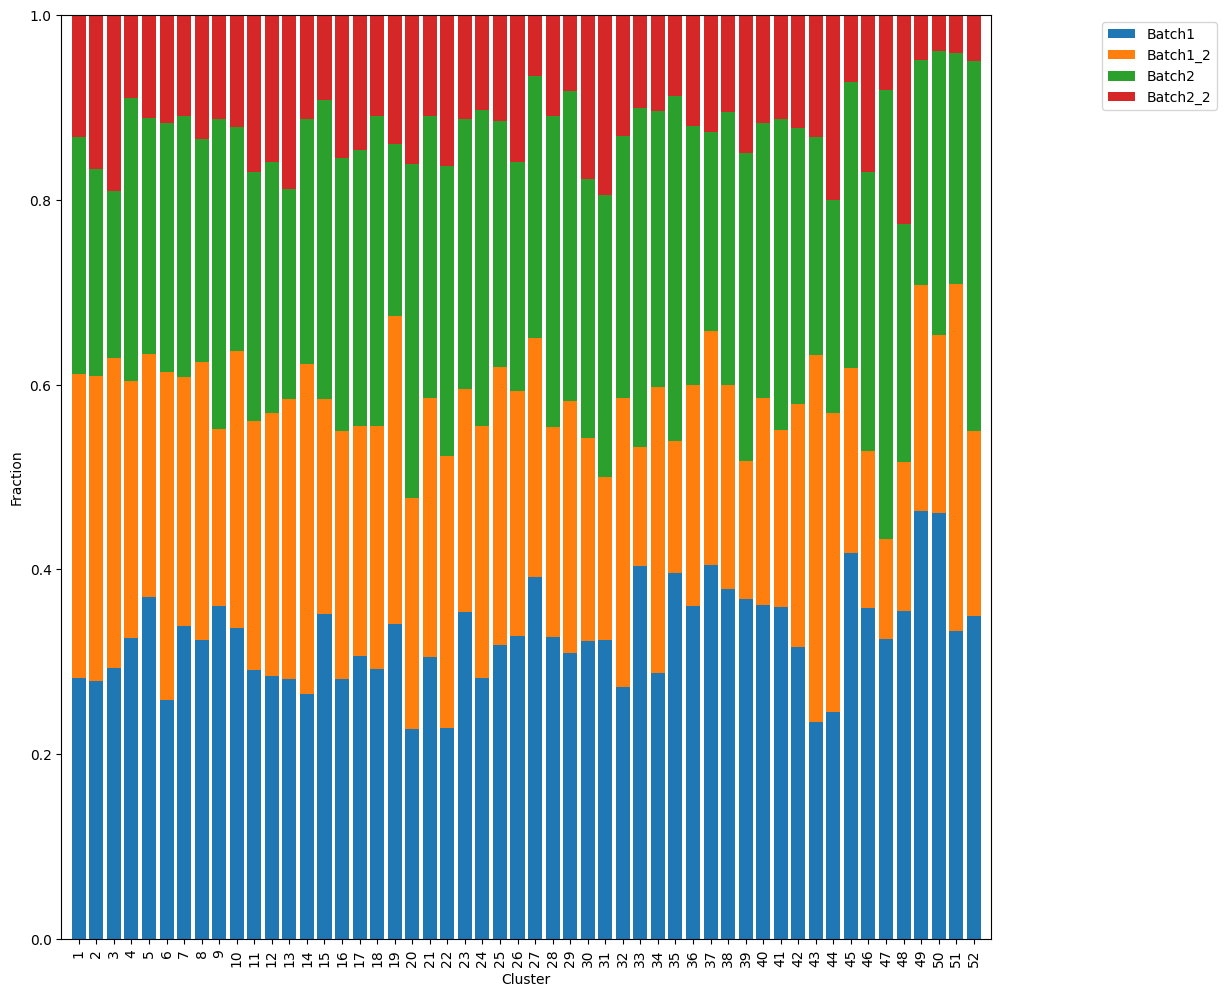

In [54]:
validation_plot(unclustered_test_validation_data, true_test_labels, unclustered_test_validation_batches, test_model, list(test_adata.var_names), 'New_Beta2_P7_Validation.pdf', 'New_Beta2_P7_Barplot.pdf')

In [55]:
ref_gains = ref_model.get_score(importance_type='gain')

In [56]:
sorted_ref_gains_indices = np.flip(np.argsort(list(ref_gains.values())))
sorted_ref_gains = {list(ref_gains.keys())[i]: list(ref_gains.values())[i] for i in sorted_ref_gains_indices}

In [57]:
test_gains = test_model.get_score(importance_type='gain')

In [58]:
sorted_test_gains_indices = np.flip(np.argsort(list(test_gains.values())))
sorted_test_gains = {list(test_gains.keys())[i]: list(test_gains.values())[i] for i in sorted_test_gains_indices}

In [59]:
num_discrim_genes = 500
ref_discrim_genes = list(sorted_ref_gains.keys())[:num_discrim_genes]
test_discrim_genes = list(sorted_test_gains.keys())[:num_discrim_genes]
discrim_genes = []
for i in range(len(ref_discrim_genes)):
    if ref_discrim_genes[i] in test_discrim_genes:
        discrim_genes.append(ref_discrim_genes[i])

In [60]:
overall_train_adata = ref_adata[:, discrim_genes]
overall_train_data = overall_train_adata.X.toarray()
overall_dtrain = xgb.DMatrix(overall_train_data, label=ref_labels)
overall_model = xgb.train(xgb_ref_params, overall_dtrain)

In [61]:
overall_test_adata = test_adata[:, discrim_genes]
overall_test_data = overall_test_adata.X.toarray()
overall_dtest = xgb.DMatrix(overall_test_data)
test_preds = overall_model.predict(overall_dtest)

In [62]:
test_real_labels = test_adata.obs['Type_num']

In [65]:
test_pred_labels = []
for i in test_preds:
    if max(i) >= 0.05:
        test_pred_labels.append(np.argmax(i)+1)
    else:
        test_pred_labels.append(0)

In [66]:
plot_real_labels = []
plot_pred_labels = []
for i in range(len(test_pred_labels)):
    if test_pred_labels[i] != 0:
        plot_real_labels.append(test_real_labels[i])
        plot_pred_labels.append(test_pred_labels[i])

In [67]:
biological_types = ["1_W3L1",
                    "2_W3D1",
                    "3_F-mini-ON",
                    "4_F-mini-OFF",
                    "5_J-RGC",
                    "6_W3B",
                    "7_Novel",
                    "8_Novel",
                    "9_Tbr1-Novel",
                    "10_ooDSGC",
                    "11_Novel",
                    "12_N-ooDSGC",
                    "13_W3L2",
                    "14_Novel",
                    "15_Novel",
                    "16_D/V-ooDSGC",
                    "17_Tbr1-S1",
                    "18_Novel",
                    "19_Novel",
                    "20_Novel",
                    "21_Tbr1-S2",
                    "22_MX",
                    "23_W3D2",
                    "24_ooDSGC",
                    "25_Novel",
                    "26_Novel",
                    "27_Novel",
                    "28_F-midi-OFF",
                    "29_Novel",
                    "30_W3D3",
                    "31_M2",
                    "32_F-Novel",
                    "33_M1",
                    "34_Novel",
                    "35_Novel",
                    "36_Novel",
                    "37_Novel",
                    "38_F-midi-ON",
                    "39_Novel",
                    "40_M1-duplicate",
                    "41_alphaON-T",
                    "42_alphaOFF-S",
                    "43_alphaON-S/M4",
                    "44_Novel",
                    "45_alphaOFF-T"
]

In [68]:
biological_labels = []
for i in plot_pred_labels:
    biological_labels.append(biological_types[i-1])

[19, 3, 11, 12, 16, 10, 13, 17, 35, 14, 2, 21, 8, 23, 32, 24, 25, 34, 18, 29, 1, 28, 36, 37, 30, 38, 43, 26, 4, 45, 49, 42, 7, 15, 6, 9, 5, 20, 22, 27, 31, 33, 39, 40, 41, 44, 46, 47, 48, 50, 51, 52]


C:\Users\pomat\Documents\PhD\Research\B2 Paper\PlotConfusion.py:103: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(['0%','20%','40%','60%','80%','100%'])


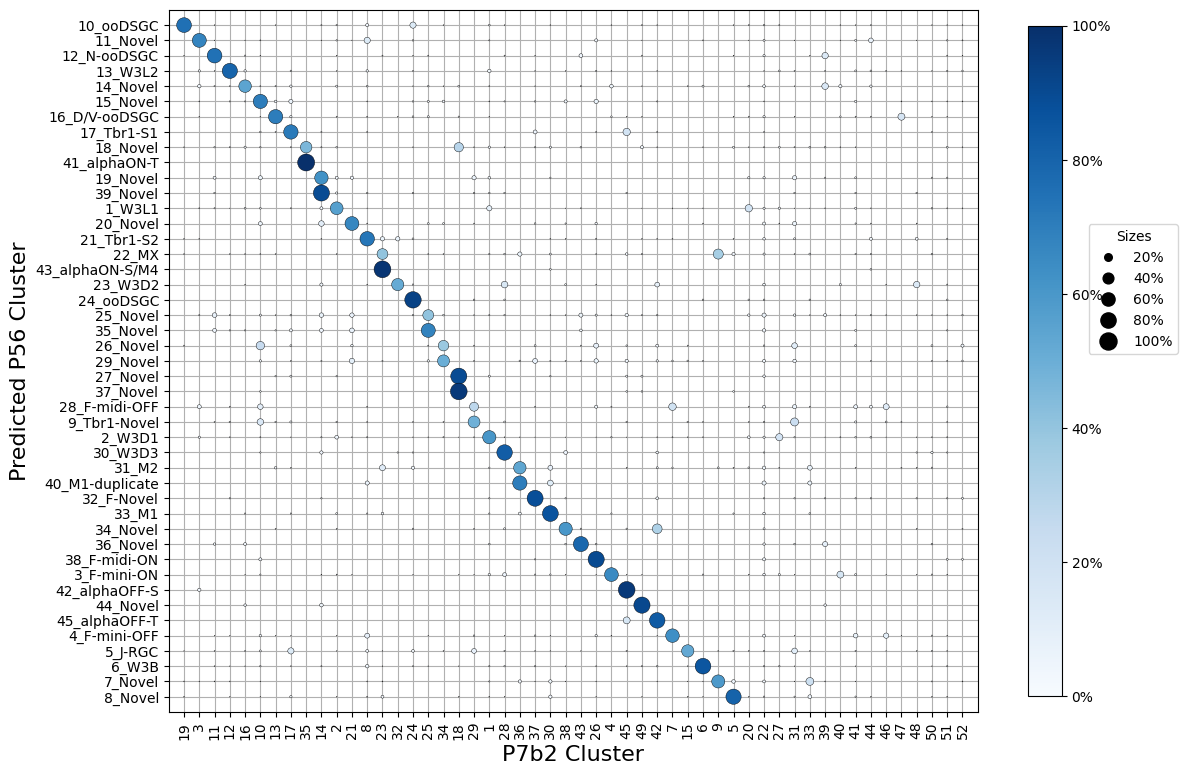

In [69]:
conf_fracs = plot_confusion(plot_real_labels, biological_labels, 'Mapping_Class1.pdf', 'P7b2 Cluster', 'Predicted P56 Cluster')

In [70]:
mappings = []
for i in conf_fracs[0]:
    mapping_i = []
    for j in range(len(i)):
        if i[j] >= 0.15:
            mapping_i.append(conf_fracs[1][j])
    mappings.append(mapping_i)

In [71]:
for i in range(len(mappings)):
    print(conf_fracs[2][i], ':', mappings[i])

10_ooDSGC : [19]
11_Novel : [3]
12_N-ooDSGC : [11]
13_W3L2 : [12]
14_Novel : [16, 39]
15_Novel : [10]
16_D/V-ooDSGC : [13, 47]
17_Tbr1-S1 : [17, 45]
18_Novel : [18, 35]
19_Novel : [14]
1_W3L1 : [2, 20]
20_Novel : [21]
21_Tbr1-S2 : [8]
22_MX : [9, 23]
23_W3D2 : [28, 32]
24_ooDSGC : [24]
25_Novel : [25]
26_Novel : [10, 34]
27_Novel : [18]
28_F-midi-OFF : [7, 29]
29_Novel : [34]
2_W3D1 : [1, 27]
30_W3D3 : [28]
31_M2 : [36]
32_F-Novel : [37]
33_M1 : [30]
34_Novel : [38, 42]
35_Novel : [25]
36_Novel : [43]
37_Novel : [18]
38_F-midi-ON : [26]
39_Novel : [14]
3_F-mini-ON : [4, 40]
40_M1-duplicate : [36]
41_alphaON-T : [35]
42_alphaOFF-S : [45]
43_alphaON-S/M4 : [23]
44_Novel : [49]
45_alphaOFF-T : [42, 45]
4_F-mini-OFF : [7]
5_J-RGC : [15]
6_W3B : [6]
7_Novel : [9, 33]
8_Novel : [5]
9_Tbr1-Novel : [29, 31]


['2_W3D1', '1_W3L1', '11_Novel', '3_F-mini-ON', '8_Novel', '6_W3B', '4_F-mini-OFF', '21_Tbr1-S2', '7_Novel', '15_Novel', '12_N-ooDSGC', '13_W3L2', '16_D/V-ooDSGC', '39_Novel', '5_J-RGC', '14_Novel', '17_Tbr1-S1', '18_Novel', '10_ooDSGC', '20_Novel', '22_MX', '24_ooDSGC', '25_Novel', '38_F-midi-ON', '30_W3D3', '9_Tbr1-Novel', '33_M1', '23_W3D2', '29_Novel', '31_M2', '32_F-Novel', '34_Novel', '36_Novel', '44_Novel', '26_Novel', '19_Novel', '27_Novel', '28_F-midi-OFF', '35_Novel', '37_Novel', '40_M1-duplicate', '41_alphaON-T', '42_alphaOFF-S', '43_alphaON-S/M4', '45_alphaOFF-T']


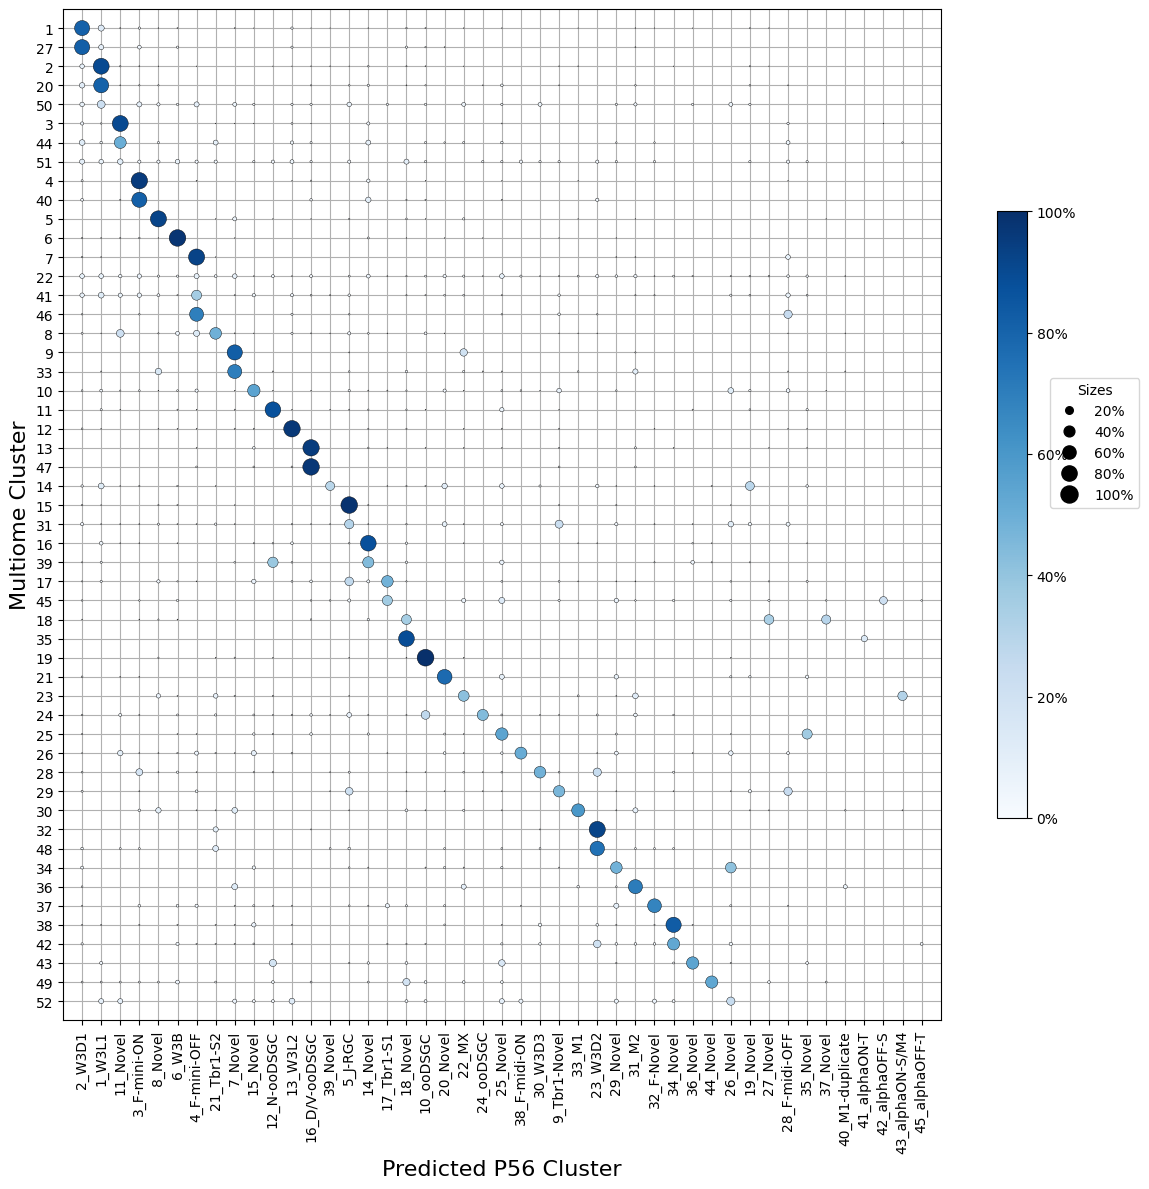

In [72]:
conf_fracs_trans = plot_confusion(biological_labels, plot_real_labels, 'Mapping_Class1.pdf', 'Predicted P56 Cluster', 'Multiome Cluster')

In [73]:
len(test_preds)

16684

In [74]:
len(test_pred_labels)

16684

In [75]:
test_real_labels.cat.categories

Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52],
      dtype='int64')

In [76]:
max_mapped_fractions = []
for i in range(len(conf_fracs[0][0])):
    col = np.array(conf_fracs[0])[:,i]
    max_mapped_fractions.append(max(col))

In [77]:
mean_mapping_probs = []
label_entropies = []
for i in test_real_labels.cat.categories:
    cluster_indices = [j for j in range(len(test_real_labels)) if test_real_labels[j] == i]
    cluster_count = len(cluster_indices)
    cluster_mapping_probs = []
    cluster_P56_labels = []
    for j in cluster_indices:
        cluster_mapping_probs.append(max(test_preds[j]))
        cluster_P56_labels.append(list(test_preds[j]).index(max(test_preds[j])))
    cluster_P56_label_props = []
    for j in range(len(biological_labels)):
        cluster_P56_label_props.append(cluster_P56_labels.count(j)/cluster_count)
    mean_mapping_probs.append(np.mean(cluster_mapping_probs))
    label_entropies.append(entropy(cluster_P56_label_props))

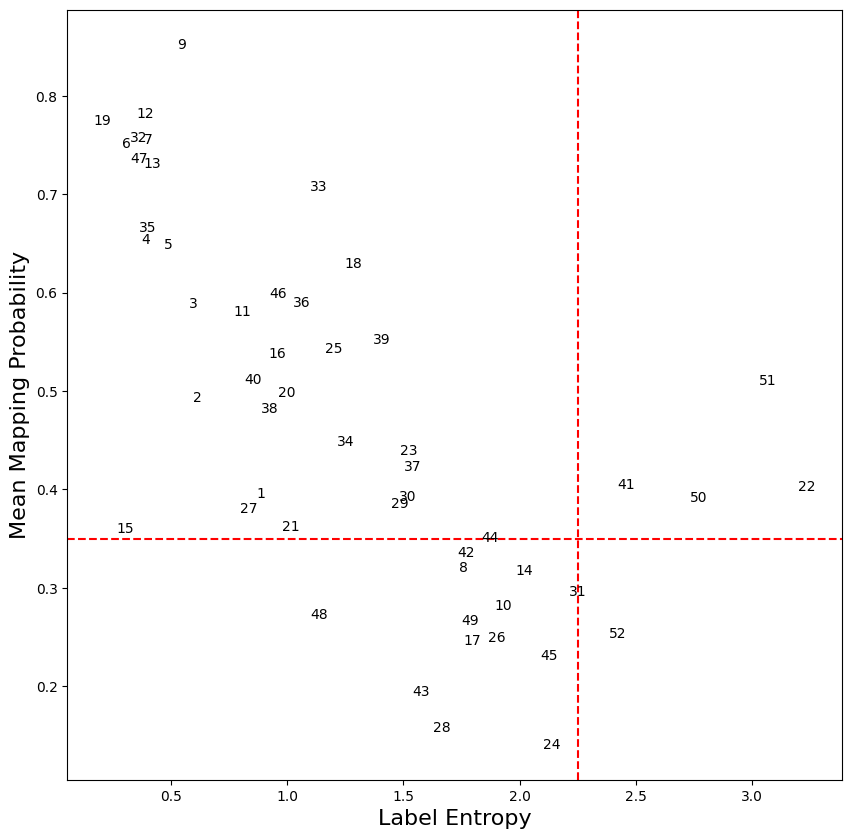

In [79]:
fig, ax = plt.subplots(figsize=(10,10))
# ax.scatter(max_mapped_fractions, mean_mapping_probs)
ax.axhline(0.35,ls='dashed',c='red')
ax.axvline(2.25,ls='dashed',c='red')
ax.set_xlabel('Label Entropy',fontsize=16)
ax.set_ylabel('Mean Mapping Probability',fontsize=16)
ax.scatter(label_entropies, mean_mapping_probs, alpha=0)
eliminated_clusters = []
for i in range(len(label_entropies)):
    ax.annotate(test_real_labels.cat.categories[i],(label_entropies[i], mean_mapping_probs[i]),ha='center',va='center')
    if (label_entropies[i] > 2.25) and (mean_mapping_probs[i] < 0.35):
        eliminated_clusters.append(test_real_labels.cat.categories[i])

In [80]:
eliminated_clusters

[31, 52]

In [87]:
biological_assignments = []
for i in range(len(ref_adata.obs)):
    bio_assign = biological_types[ref_adata.obs["Type_num"][i]-1]
    biological_assignments.append(bio_assign)
ref_adata.obs["Bio_type"] = pd.Categorical(biological_assignments)

In [88]:
test_adata.obs["P56_type"] = pd.Categorical(test_pred_labels)

C:\Users\pomat\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


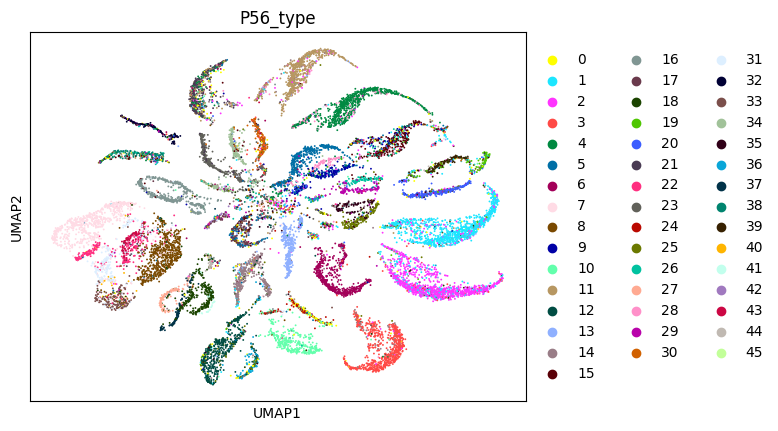

In [89]:
sc.pl.umap(test_adata, color='P56_type')

C:\Users\pomat\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


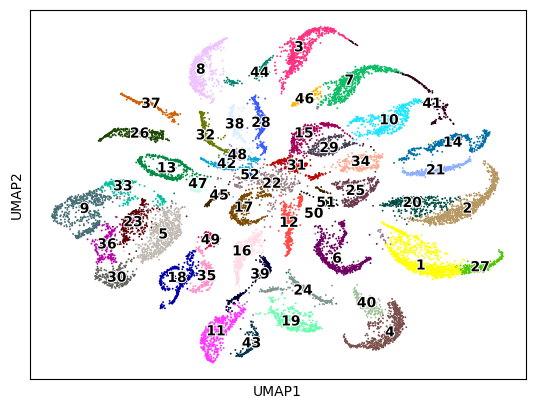

In [90]:
sc.pl.umap(test_adata, color='Cluster', legend_loc='on data', legend_fontoutline=1.5, legend_fontsize=10, title='')

In [91]:
test_adata.write('path/to/adatas/P7b2_adata_typed.h5ad')